# An introduction to Sparse Identification of Nonlinear Dynamical systems (SINDy)
This notebook gives an overview of the Sparse Identification of Nonlinear Dynamical systems (SINDy) method and discusses the relationship between SINDy and PySINDy. It also includes a brief example showing how different objects in the SINDy method are represented in PySINDy.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/dynamicslab/pysindy/v1.4.3?filepath=examples/2_introduction_to_sindy.ipynb)

## Main ideas
Suppose we have a set of measurements $x(t)\in \mathbb{R}^n$ from some physical system at different points in time $t$. SINDy seeks to represent the time evolution of $x(t)$ in terms of a nonlinear function $f$:

$$ \frac{d}{dt}x(t) = f(x(t)). $$

This equation constitutes a *dynamical system* for the measurements $x(t)$. The vector $x(t)=[x_1(t), x_2(t), \dots x_n(t)]^\top$ gives the state of the physical system at time $t$. The function $f(x(t))$ constrains how the system evolves in time.

The key idea behind SINDy is that the function $f$ is often **sparse** in the space of an appropriate set of basis functions. For example, the function

$$ 
	\frac{d}{dt}x = f(x)
	= \begin{bmatrix} f_1(x)\\f_2(x) \end{bmatrix}
	= \begin{bmatrix}1 - x_1 + 3x_1x_2 \\ x_2^2 - 5x_1^3 \end{bmatrix}
$$

is sparse with respect to the set of polynomials of two variables in the sense that if we were to write an expansion of the component functions of $f$ in this basis (e.g. $f_{1}(x) = \sum_{i=0}^\infty\sum_{j=0}^\infty a_{i,j}x_1^ix_2^j$), only a small number of coefficients ($a_{i,j}$) would be nonzero.

SINDy employs **sparse regression** to find a linear combination of basis functions that best capture the dynamic behavior of the physical system.

## Approximation problem
To apply SINDy in practice one needs a set of measurement data collected at times $t_1, t_2, \dots, t_n$, and the time derivatives of these measurements (either measured directly or numerically approximated). These data are aggregated into the matrices $X$ and $\dot X$, respectively

$$
	X = \begin{bmatrix}
		x_1(t_1) & x_2(t_1) & \dots & x_n(t_1) \\
		x_1(t_2) & x_2(t_2) & \dots & x_n(t_2) \\
		\vdots & \vdots & & \vdots \\ x_1(t_m) & x_2(t_m) & \dots & x_n(t_m)
	\end{bmatrix},
	\qquad
	\dot{X} = \begin{bmatrix} \dot{x_1}(t_1) & \dot{x_2}(t_1) & \dots & \dot{x_n}(t_1) \\
		\dot{x_1}(t_2) & \dot{x_2}(t_2) & \dots & \dot{x_n}(t_2) \\
		\vdots & \vdots & & \vdots \\
		\dot{x_1}(t_m) & \dot{x_2}(t_m) & \dots & \dot{x_n}(t_m)
	\end{bmatrix}.
$$

Next, one forms a library matrix $\Theta(X)$ whose columns consist of a chosen set of basis functions applied to the data

$$
	\Theta(X) = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\theta_1(X) & \theta_2(X) & \dots & \theta_\ell(X) \\
		\mid & \mid & & \mid 
	\end{bmatrix}.
$$

For example, if $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ are monomials ($\theta_i(x) = x^{i-1}$), then 

$$
	\theta_3(X) = \begin{bmatrix}
		\mid & \mid & & \mid & \mid & & \mid \\
		x_1(t)^2 & x_1(t)x_2(t) & \dots & x_2(t)^2 & x_2(t)x_3(t) & \dots & x_n^2(t) \\
		\mid & \mid & & \mid & \mid & & \mid
	\end{bmatrix},
$$

where vector products and powers are understood to be element-wise.

We seek a set of sparse coefficient vectors (collected into a matrix)

$$
	\Xi = \begin{bmatrix}
		\mid & \mid & & \mid \\
		\xi_1 & \xi_2 & \dots & \xi_n \\
		\mid & \mid & & \mid
	\end{bmatrix}.
$$

The vector $\xi_i$ provides the coefficients for a linear combination of basis functions $\theta_1(x), \theta_2(x), \dots, \theta_\ell(x)$ representing the $i$th component function of $f$: $f_i(x)$. That is to say, $f_i(x) = \Theta\left(x^\top\right) \xi_i$, where $\Theta\left(x^\top\right)$ is understood to be a row vector consisting of symbolic functions (whereas $\Theta(X)$ is a matrix whose entries are numerical values).

With each of the objects $X$, $\dot X$, $\Theta(X)$, and $\Xi$ being defined, we are ready to write down the approximation problem underlying SINDy:

$$ \dot X \approx \Theta(X)\Xi. $$

## Structure of PySINDy
The submodules of PySINDy are each aligned with one of the terms in the aforementioned approximation equation

$$ \dot X \approx \Theta(X)\Xi. $$

 * `pysindy.differentiate` performs numerical differentiation to compute $\dot X$ from $X$;
 * `pysindy.feature_library` allows the user to specify a set of library functions and handles the formation of $\Theta(X)$;
 * `pysindy.optimizers` provides a set of sparse regression solvers for determining $\Xi$.

The `SINDy` object encapsulates one class object from each of these three submodules and uses them, along with a user-supplied data matrix, to find a governing dynamical system.

Let's walk through an example showing how this works using a toy dataset.

## Example
Suppose we have measurements of the position of a particle obeying the following dynamical system at different points in time:

$$
	\frac{d}{dt} \begin{bmatrix} x \\ y \end{bmatrix}
	= \begin{bmatrix} -2x \\ y \end{bmatrix}
	= \begin{bmatrix} -2 & 0 \\ 0 & 1 \end{bmatrix}
	\begin{bmatrix} x \\ y \end{bmatrix}
$$

Note that this system of differential equations decouples into two differential equations whose solutions are simply $x(t) = x_0e^{-2t}$ and $y(t) = y_0e^t$, where $x_0 = x(0)$ and $y_0=y(0)$ are the initial conditions.

Using the initial conditions $x_0 = 3$ and $y_0 = \tfrac{1}{2}$, we construct the data matrix $X$.

In [1]:
import numpy as np
import pysindy as ps

In [2]:
t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1)  # First column is x, second is y

We can select a differentiation method from the `differentiation` submodule.

In [3]:
differentiation_method = ps.FiniteDifference(order=2)

# We could instead call ps.differentiation.FiniteDifference(order=2)

While we could use this method to compute $\dot X$ "by hand," it is often more convenient to pass it into the `SINDy` object and let the computation of $\dot X$ be handled automatically.

The candidate library can be specified with an object from the `feature_library` submodule, which will also be passed into the `SINDy` object.

In [4]:
feature_library = ps.PolynomialLibrary(degree=3)

# Note: We could instead call ps.feature_library.PolynomialLibrary(degree=3)

Next we select which optimizer should be used.

In [5]:
optimizer = ps.STLSQ(threshold=0.2)

# Note: We could instead call ps.optimizers.STLSQ(threshold=0.2)

Finally, we bring these three components together in one `SINDy` object.

In [6]:
model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)

Following the `scikit-learn` workflow, we first instantiate a `SINDy` class object with the desired properties, then fit it to the data in separate step.

In [7]:
model.fit(X, t=t);

We can inspect the governing equations discovered by the model and check whether they seem reasonable with the `print` function.

In [8]:
model.print()

(x)' = -2.000 x
(y)' = 1.000 y


Once the SINDy model has been fit we can use it to evolve new initial conditions forward in time with the `simulate` function.

In [9]:
x0 = 6
y0 = -0.1

t_test = np.linspace(0, 1, 100)
x_test = x0 * np.exp(-2 * t_test)
y_test = y0 * np.exp(t_test)

sim = model.simulate([x0, y0], t=t_test)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


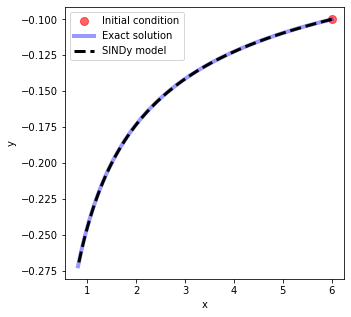

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(x0, y0, "ro", label="Initial condition", alpha=0.6, markersize=8)
ax.plot(x_test, y_test, "b", label="Exact solution", alpha=0.4, linewidth=4)
ax.plot(sim[:, 0], sim[:, 1], "k--", label="SINDy model", linewidth=3)
ax.set(xlabel="x", ylabel="y")
ax.legend()
fig.show()

Note that if the library we had chosen had been inappropriate for the problem at hand (i.e. if the dynamics could not be well-approximated as a sparse linear combination of library functions), then SINDy would have failed to produce a reasonable model. For example, if we solve the same problem, but using sines and cosines as our basis functions, SINDy is unable to find a sparse model for the dynamics:

In [11]:
# Populate the library with trigonometric functions
feature_library = ps.FourierLibrary()

model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["x", "y"]
)
model.fit(X, t=t)
model.print()

(x)' = 0.772 sin(1 x) + 2.097 cos(1 x) + -2.298 sin(1 y) + -3.115 cos(1 y)
(y)' = 1.362 sin(1 y) + -0.222 cos(1 y)
